# year-in-review

In [3]:
import os
from github import Github

import pandas as pd
from tqdm.notebook import tqdm
from time import sleep
import matplotlib.pyplot as plt

In [4]:
public_access_token = os.environ["GH_PUBLIC_ACCESS_TOKEN"]
g = Github(public_access_token)

## Time

In [4]:
import os
import requests

In [5]:
api_token = os.environ["TOGGL_API_TOKEN"]
password = os.environ["TOGGL_PASSWORD"]
mail = "g.duran@me.com"

In [7]:
headers = {
    "Content-Type": "application/json"
}

In [8]:
url_me = "https://api.track.toggl.com/api/v8/me"
r = requests.get(url_me, headers=headers, auth=(mail, password))
data = r.json()["data"]
print(data["fullname"], data["created_at"])

Gerardo Durán 2015-04-28T02:55:50+00:00


In [9]:
url_workspace = "https://api.track.toggl.com/api/v8/workspaces"
r = requests.get(url_workspace, headers=headers, auth=(mail, password))

In [24]:
list_workspaces = r.json()
list_workspaces
for workspace_data in list_workspaces:
    workspace_name = workspace_data["name"]
    workspace_id = workspace_data["id"]
    
    print(f"{workspace_name:>10}: id-{workspace_id}")

  Personal: id-921814
      QMUL: id-4657976
  Sapienza: id-4666718
  QMUL-PhD: id-5608619


In [27]:
workspace_id = 4657976

In [28]:
url_projects = f"https://api.track.toggl.com/api/v8/workspaces/{workspace_id}/projects"
r = requests.get(url_projects, headers=headers, auth=(mail, password))

In [34]:
list_projects = r.json()

In [37]:
for project_data in list_projects:
    print(project_data["name"])

7CCMCS06T: Elements of Statistical Learning
managerial
MTH6107: Chaos and Fractals
MTH700P: Research Methods in Mathematical Sciences
MTH739P: Topics in Scientific Computing
MTH743P: Complex Systems
MTH744P: Dynamical Systems
MTH750: Graphs and Networks
MTH776P: Bayesian Statistics
MTH793P: Advanced Machine Learning
MTHM038: Project Dissertation
research
talks


In [63]:
def extract_report(api_token, workspace_id, start_date, end_date, project_id=None, page=1):
    url_details = "https://api.track.toggl.com/reports/api/v2/details"
    
    params = {
        "user_agent": mail,
        "workspace_id": workspace_id,
        "since": start_date,
        "until": end_date,
        "page": page,
    }
    
    if project_id is not None:
        dict_pid = {"project_ids": project_id}
        params = {**params, **dict_pid}
    
    r = requests.get(url_details, params=params, auth=(api_token, "api_token"))
    r.raise_for_status()
    
    return r

In [104]:
%config InlineBackend.figure_format = "retina"

In [80]:
total_info = []
start_date = "2020-01-01"
end_date = "2021-01-01"

page = 1
r = extract_report(api_token, workspace_id, start_date, end_date, page=page)
info = r.json()

n_pages = info["total_count"] // info["per_page"] + 1

for page in tqdm(range(2, n_pages + 1)):
    info = extract_report(api_token, workspace_id, start_date, end_date, page=page).json()
    total_info.extend(info["data"])
    sleep(1)

  0%|          | 0/12 [00:00<?, ?it/s]

In [89]:
len(total_info)

557

In [97]:
timeline = pd.DataFrame(total_info).set_index("start")

timeline.index = pd.to_datetime(timeline.index, utc=True).tz_convert("Europe/London")
timeline = timeline.sort_index()

timeline["clocked_hours"] = timeline["dur"] * 0.001 / 60 ** 2

In [111]:
timeline.groupby("project")["clocked_hours"].sum()

project
7CCMCS06T: Elements of Statistical Learning           112.506389
MTH6107: Chaos and Fractals                             4.774167
MTH700P: Research Methods in Mathematical Sciences     84.628791
MTH739P: Topics in Scientific Computing               132.173333
MTH744P: Dynamical Systems                            169.972222
MTHM038: Project Dissertation                          18.858611
managerial                                             78.012311
talks                                                   2.396944
Name: clocked_hours, dtype: float64

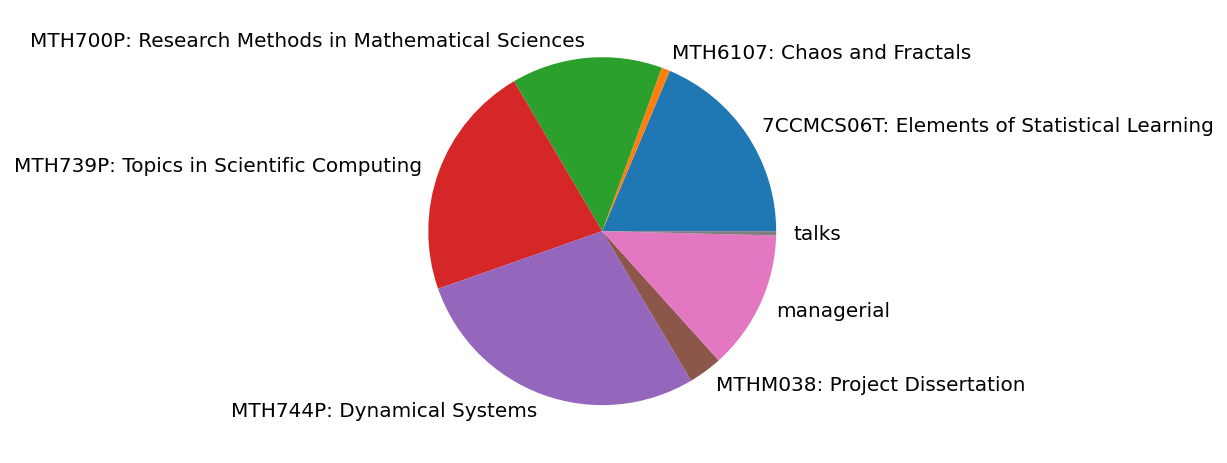

In [110]:
timeline.groupby("project")["clocked_hours"].sum().plot(kind="pie")
plt.ylabel(None);